# cmip Impacts by Event Type

This file makes lots of contour plots for rainfall and temperature anomalies under different individal and compound event types



In [1]:
import xarray
import numpy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


In [2]:
#import my functions
import utils._modelDefinitions as _model
%run helpers/impactPlots.ipynb
%run utils/emergence.ipynb


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
indexSet='ecCombinedDmiSam'

In [5]:
def detrend(xr):
    return xr-xr.rolling(year=30,min_periods=15,center=True).mean('year')

# Import Data

Import events

In [6]:
allCompounds=xarray.open_dataset('results/cmip6Compounds.nc').sel(experiment='ssp585',year=slice(1850,2099),drop=True)

In [7]:
#List of events to plot
eventsList=[
    #'everything',
    #'no',
    #'noFirePos', 
    #'enso','iod','sam', 
    *allCompounds.pairs, 
    'all3'
]
eventsList

['enso+iod', 'enso+sam', 'iod+sam', 'all3']

Import seasonal impacts

In [9]:
prXr=(xarray.open_dataset('results/cmip6PrXr.nc'))
detrendTsXr=xarray.open_dataset('results/cmip6DetrendTsXr.nc')


# Impact plots for compounds events

For:
- fire promoting and not promoting, 
- in each season, 
- for each combination of compound events,

plot mean rainfall and temperature anomalies

In [ ]:
%run helpers/impactPlots.ipynb

resultsDir='figures/cmipCompoundImpact'+indexSet.capitalize()+'/'


for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=multiPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('ALL3')
        plt.savefig(
            resultsDir
            +iFire
            +iSeason.capitalize()
            +indexSet.capitalize()
            +'Rain.pdf',
            bbox_inches='tight'
        )
        plt.show()
        
        axs=multiPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), 
            eventsList,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('ALL3')
        plt.savefig(
            resultsDir
            +iFire
            +iSeason.capitalize()
            +indexSet.capitalize()
            +'Temp.pdf',
            bbox_inches='tight'
        )
        plt.show()

# Now pair them by how the frequencies change

In [11]:
%run helpers/impactPlots.ipynb

Dry compounds - cool season

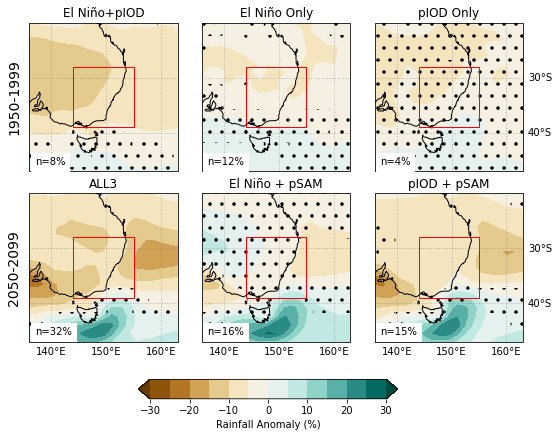

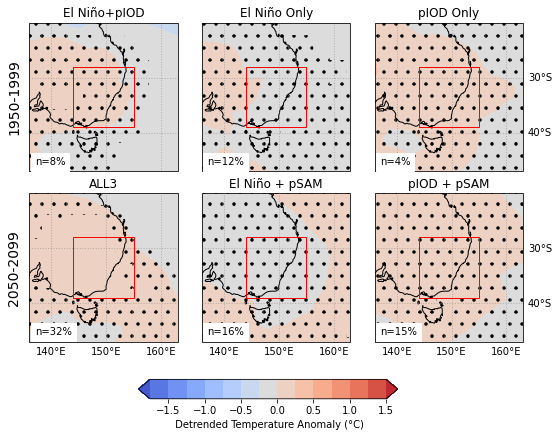

In [13]:
import matplotlib.cm as cm
import matplotlib.colorbar as cb
for iImpact in ['Rain','Temp']:
    nRows=2
    nCols=3

    fig=plt.figure(figsize=(nCols*3,nRows*4+1))

    #First row is years 1950 to 1999
    with allCompounds[indexSet+'winter'].sel(year=slice(1950,1999),fire='pos',drop=True) as firstRow:

        #First cell is ENSO+IOD
        ax=plt.subplot(nRows+1,nCols,1,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'enso+iod','winter',iImpact)
        ax.set_title('El Niño+pIOD')
        gl.bottom_labels=False
        gl.right_labels=False

        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('1950-1999'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

        #2nd cell is ENSO only
        ax=plt.subplot(3,3,2,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'enso','winter',iImpact)
        ax.set_title('El Niño Only')
        gl.bottom_labels=False
        gl.right_labels=False

        #3rd cell is IOD only
        ax=plt.subplot(3,3,3,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'iod','winter',iImpact)
        ax.set_title('pIOD Only')
        gl.bottom_labels=False

    #Second row is years 2050 to 2099
    with allCompounds[indexSet+'winter'].sel(year=slice(2050,2099),fire='pos',drop=True) as secondRow:
        #First cell is All3
        ax=plt.subplot(3,3,4,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'all3','winter',iImpact)
        ax.set_title('ALL3')
        gl.right_labels=False
        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('2050-2099'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

        #2nd cell is ENSO + SAM only
        ax=plt.subplot(3,3,5,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'enso+sam','winter',iImpact)
        ax.set_title('El Niño + pSAM')
        gl.right_labels=False

        #3rd cell is IOD only
        ax=plt.subplot(3,3,6,projection=ccrs.PlateCarree())
        cs,gl = singleAnomWithStipling(secondRow,'iod+sam','winter',iImpact)
        ax.set_title('pIOD + pSAM')

    # add some space between rows
    plt.subplots_adjust(hspace=0.15, wspace=0.1)

    if iImpact=='Rain':
        label = 'Rainfall Anomaly (%)'
    elif iImpact=='Temp':
        label = ' Detrended Temperature Anomaly (°C)'
    
    #put a color bar on
    ax=fig.add_axes([0.3,0.3,0.4,0.03])
    cbar=plt.colorbar(
        cm.ScalarMappable(cs.norm,cs.cmap),
        orientation='horizontal', 
        cax=ax, 
        extend='both', 
        boundaries=cs.get_array(), 
        label=label
    )

    plt.savefig('figures/curatedImpactPlots/cmipDryWinter'+iImpact+'.pdf', bbox_inches='tight')

Dry compounds - warm season

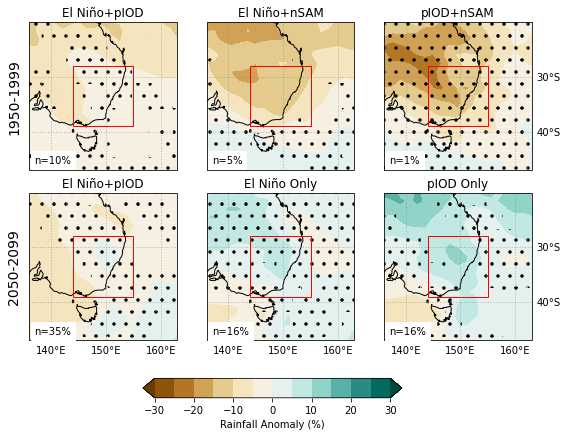

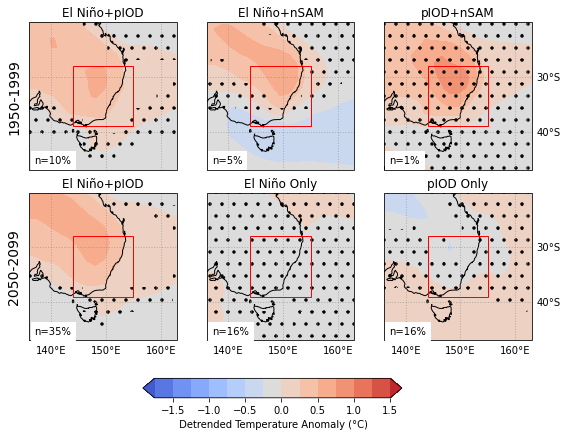

In [14]:
import matplotlib.cm as cm
import matplotlib.colorbar as cb
for iImpact in ['Rain','Temp']:

    nRows=2
    nCols=3
    fig=plt.figure(figsize=(nCols*3,nRows*4+1))

    #First row is years 1950 to 1999
    with allCompounds[indexSet+'summer'].sel(year=slice(1950,1999),fire='pos',drop=True) as firstRow:

        #First cell is ENSO+IOD
        ax=plt.subplot(nRows+1,nCols,1,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'enso+iod','summer',iImpact)
        ax.set_title('El Niño+pIOD')
        gl.bottom_labels=False
        gl.right_labels=False

        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('1950-1999'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

        #2nd cell is ENSO only
        ax=plt.subplot(nRows+1,nCols,2,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'enso+sam','summer',iImpact)
        ax.set_title('El Niño+nSAM')
        gl.bottom_labels=False
        gl.right_labels=False


        #3rd cell is IOD only
        ax=plt.subplot(nRows+1,nCols,3,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'iod+sam','summer',iImpact)
        ax.set_title('pIOD+nSAM')
        gl.bottom_labels=False


    #Second row is years 2050 to 2099
    with allCompounds[indexSet+'summer'].sel(year=slice(2050,2099),fire='pos',drop=True) as secondRow:
        #First cell is All3
        ax=plt.subplot(nRows+1,nCols,nCols+1,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'enso+iod','summer',iImpact)
        ax.set_title('El Niño+pIOD')
        gl.right_labels=False


        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('2050-2099'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

        #2nd cell is ENSO + SAM only
        ax=plt.subplot(nRows+1,nCols,nCols+2,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'enso','summer',iImpact)
        ax.set_title('El Niño Only')
        gl.right_labels=False

        #3rd cell is IOD only
        ax=plt.subplot(nRows+1,nCols,nCols+3,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'iod','summer',iImpact)
        ax.set_title('pIOD Only')

    # add some space between rows
    plt.subplots_adjust(hspace=0.15)

    if iImpact=='Rain':
        label = 'Rainfall Anomaly (%)'
    elif iImpact=='Temp':
        label = ' Detrended Temperature Anomaly (°C)'
    
    #put a color bar on
    ax=fig.add_axes([0.3,0.3,0.4,0.03])
    cbar=plt.colorbar(
        cm.ScalarMappable(cs.norm,cs.cmap),
        orientation='horizontal', 
        cax=ax, 
        extend='both', 
        boundaries=cs.get_array(), 
        label = label
    )

    plt.savefig('figures/curatedImpactPlots/cmipDrySummer'+iImpact+'.pdf', bbox_inches='tight')

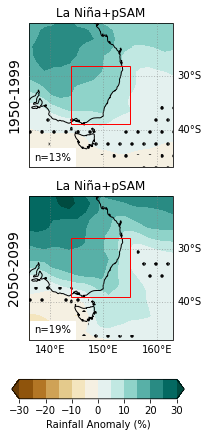

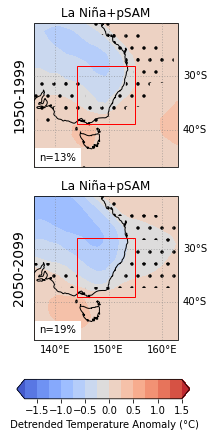

In [15]:
import matplotlib.cm as cm
import matplotlib.colorbar as cb

for iImpact in ['Rain','Temp']:

    fig=plt.figure(figsize=(3,9))

    #First row is years 1950 to 1999
    with allCompounds[indexSet+'summer'].sel(year=slice(1950,1999),fire='neg',drop=True) as firstRow:

        ax=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
        cs,gl=singleAnomWithStipling(firstRow,'enso+sam','summer',iImpact)
        ax.set_title('La Niña+pSAM')
        gl.bottom_labels=False

        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('1950-1999'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

    #Second row is years 2050 to 2099
    with allCompounds[indexSet+'summer'].sel(year=slice(2050,2099),fire='neg',drop=True) as secondRow:
        #First cell is All3
        ax=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
        cs,gl=singleAnomWithStipling(secondRow,'enso+sam','summer',iImpact)
        ax.set_title('La Niña+pSAM')

        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('2050-2099'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )


    # add some space between rows
    plt.subplots_adjust(hspace=0.2)
    
    if iImpact=='Rain':
        label = 'Rainfall Anomaly (%)'
    elif iImpact=='Temp':
        label = ' Detrended Temperature Anomaly (°C)'

    #put a color bar on
    ax=fig.add_axes([0.1,0.3,0.8,0.03])
    cbar=plt.colorbar(
        cm.ScalarMappable(cs.norm,cs.cmap),
        orientation='horizontal', 
        cax=ax, 
        extend='both', 
        boundaries=cs.get_array(), 
        label = label
    )

    plt.savefig(
        fname='figures/curatedImpactPlots/cmipWetSummer'+iImpact+'.pdf', 
        bbox_inches='tight'
    )

# ENSO comparisons

pos
winter


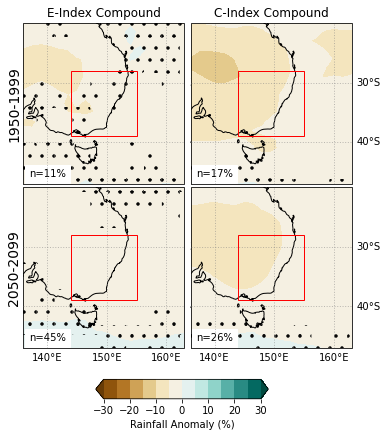

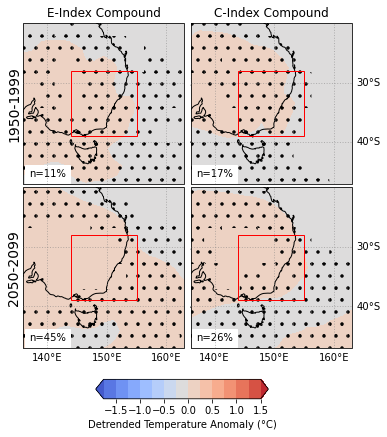

summer


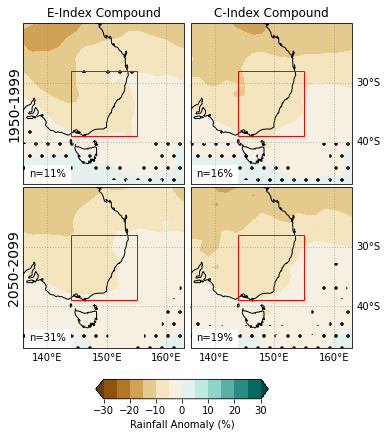

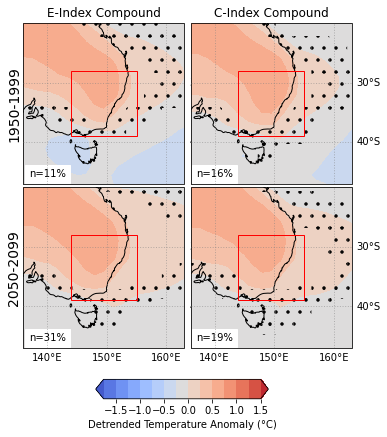

In [14]:
%run helpers/impactPlots.ipynb
for iFire in ['pos']:#,'neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
            print(iSeason)

            axs=multiPlotter(
                prXr[iSeason.capitalize()+' Rain'], #sourceData
                allCompounds[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+iod','enso+sam','all3'],drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Rainfall Anomaly (%)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')


            plt.savefig(
                'figures/ECImpacts/cmip'+iFire+iSeason.capitalize()+'EvsCpRain.pdf',
                bbox_inches='tight'
                       )
            plt.show()

            axs=multiPlotter(
                detrendTsXr[iSeason.capitalize()+' Temp'], #sourceData
                allCompounds[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+iod','enso+sam','all3'],drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Detrended Temperature Anomaly (°C)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')

            plt.savefig(
                'figures/ECImpacts/cmip'+iFire+iSeason.capitalize()+'EvsCpTemp.pdf',
                bbox_inches='tight'
            )
            plt.show()


neg
winter


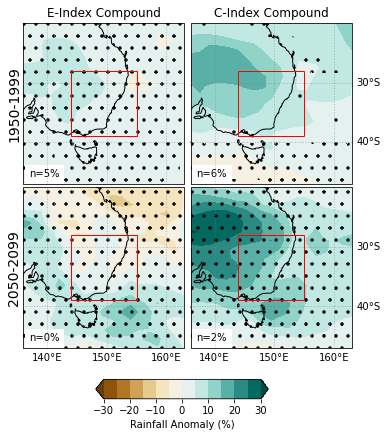

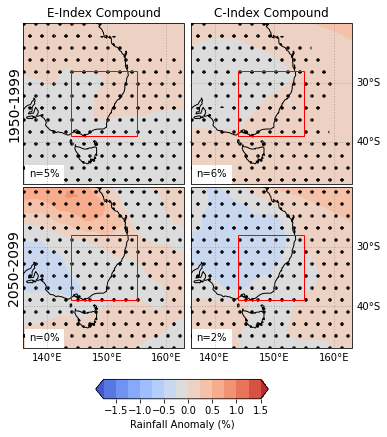

summer


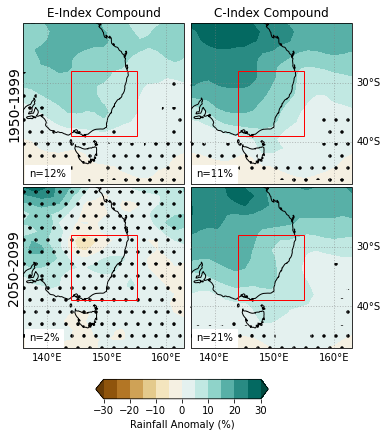

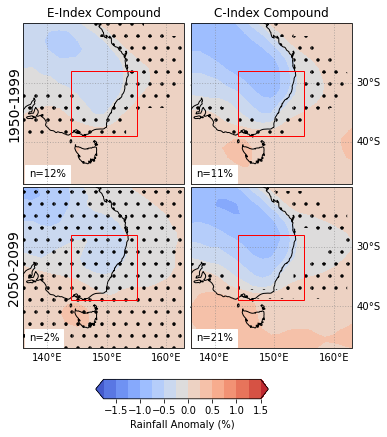

In [15]:
%run helpers/impactPlots.ipynb
for iFire in ['neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
            print(iSeason)

            axs=multiPlotter(
                prXr[iSeason.capitalize()+' Rain'], #sourceData
                allCompounds[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+sam','enso+iod','all3'],drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Rainfall Anomaly (%)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')


            plt.show()

            axs=multiPlotter(
                detrendTsXr[iSeason.capitalize()+' Temp'], #sourceData
                allCompounds[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+sam','enso+iod','all3'],drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Rainfall Anomaly (%)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')

            plt.show()


# How many are wetter/drier?

Calculate
- how many models means are wetter in C index events compared to E index events
- how many models have negative anoms for E and C index events

In [16]:
CWetter=dict()
ENeg=dict()
CNeg=dict()

for iFire in ['pos','neg']:
    CWetter['winter']=list()
    CWetter['summer']=list()
    ENeg['winter']=list()
    ENeg['summer']=list()
    CNeg['winter']=list()
    CNeg['summer']=list()
    for iModel in prXr.model.values:
        for iSeason in ['winter','summer']:
            eventAnoms=dict()
            for iIndex in ['eIndex','cIndex' ]:
                eventAnoms[iIndex]=domain(
                    prXr[iSeason.capitalize()+' Rain'].where(
                        allCompounds[iIndex+'DmiSam'+iSeason].sel(
                            compound=['enso+iod','enso+sam','all3'],
                            year=slice(1950,1999),
                            fire=iFire,
                            model=iModel,
                            drop=True
                            ).any('compound')
                        )
                    ).sel(model=iModel,drop=True).mean(['lat','lon','year'])
            CWetter[iSeason].append((eventAnoms['cIndex'].values)>(eventAnoms['eIndex'].values))
            ENeg[iSeason].append((eventAnoms['eIndex'].values)<0)
            CNeg[iSeason].append((eventAnoms['cIndex'].values)<0)

    print('C wetter than E, winter: ' + str(sum(CWetter['winter'])))
    print(sum(CWetter['summer']))
    print(sum(ENeg['winter']))
    print(sum(ENeg['summer']))
    print(sum(CNeg['winter']))
    print(sum(CNeg['summer']))

C wetter than E, winter: 13
20
27
31
37
34
C wetter than E, winter: 21
24
12
5
4
0


In [17]:
eventAnoms

{'eIndex': <xarray.DataArray 'Summer Rain' ()>
 array(13.76282017),
 'cIndex': <xarray.DataArray 'Summer Rain' ()>
 array(9.71299921)}

winterPos


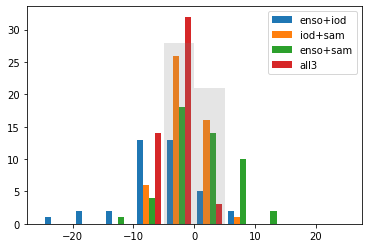

summerPos


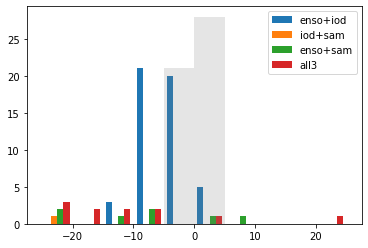

winterNeg


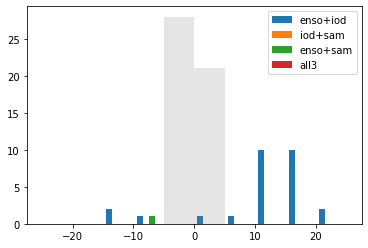

summerNeg


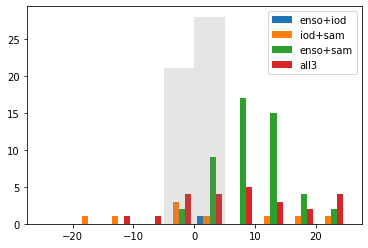

In [18]:
compounds=['enso+iod','iod+sam','enso+sam','all3']
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        print(iSeason+iFire.capitalize())
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allCompounds['ecCombinedDmiSam'+iSeason].sel(
                                    compound=compounds,
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).to_dataset('compound').mean(['model','lat','lon'])

        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=np.arange(-25,26,5)
        )

        plt.legend(compounds)
        
        
        allYears=domain(
            prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
        ).mean(['model','lat','lon'])
        
        n=plt.hist(
            allYears,
            bins=np.arange(-25,26,5), 
            alpha=0.2,
            color='grey'
        )
        
        plt.show()

winterPos
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  float64 -5.495
    iod+sam   float64 -1.352
    enso+sam  float64 2.756
    all3      float64 -4.615
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  int64 25
    iod+sam   int64 36
    enso+sam  int64 35
    all3      int64 37


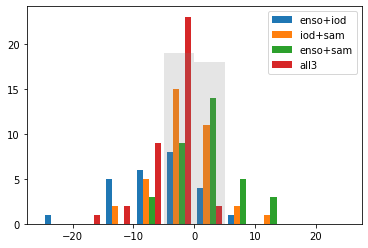

summerPos
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  float64 -4.99
    iod+sam   float64 -22.85
    enso+sam  float64 -13.15
    all3      float64 -12.67
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  int64 37
    iod+sam   int64 1
    enso+sam  int64 7
    all3      int64 4


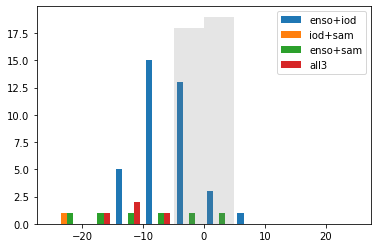

winterNeg
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  float64 12.63
    iod+sam   float64 nan
    enso+sam  float64 -5.844
    all3      float64 nan
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  int64 15
    iod+sam   int64 0
    enso+sam  int64 1
    all3      int64 0


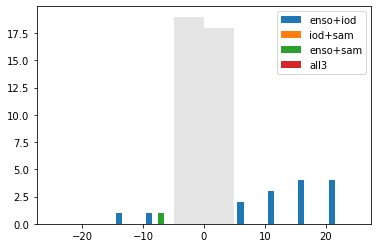

summerNeg
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  float64 1.193
    iod+sam   float64 5.445
    enso+sam  float64 8.819
    all3      float64 8.884
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  int64 1
    iod+sam   int64 5
    enso+sam  int64 37
    all3      int64 15


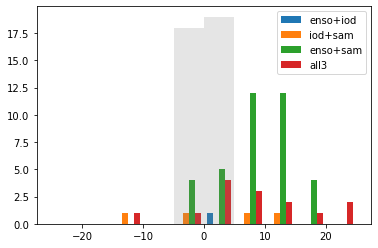

In [19]:
compounds=['enso+iod','iod+sam','enso+sam','all3']
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        print(iSeason+iFire.capitalize())
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allCompounds['ecCombinedDmiSam'+iSeason].sel(
                                    compound=compounds,
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).to_dataset('compound').mean(['year','lat','lon'])
        
        print(eventAnoms.mean('model'))
        print(eventAnoms.count())
        
        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=np.arange(-25,26,5)
        )

        plt.legend(compounds)
        
        
        allYears=domain(
            prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
        ).mean(['year','lat','lon'])
        
        n=plt.hist(
            allYears,
            bins=np.arange(-25,26,5), 
            alpha=0.2,
            color='grey'
        )
        
        plt.show()

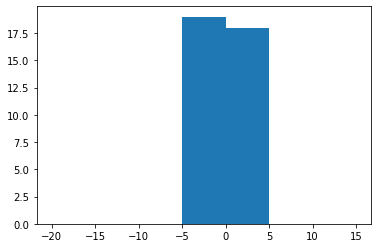

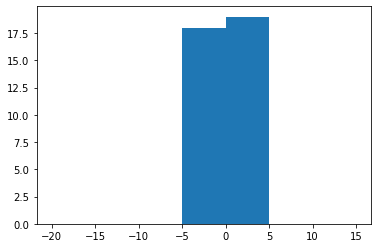

In [20]:
for iSeason in ['winter','summer']:
    allYears=domain(
        prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
    ).mean(['year','lat','lon'])

    n=plt.hist(
        allYears,
        bins=range(-20,20,5)
    )

    plt.show()

In [21]:
allEventsXr=xarray.open_dataset('results/cmipEcEvents.nc')

In [22]:
allEventsXr

<xarray.Dataset>
Dimensions:     (experiment: 2, fire: 2, model: 37, year: 5341)
Coordinates:
  * experiment  (experiment) object 'piControl' 'ssp585'
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
Data variables:
    cIndex      (fire, model, experiment, year) float64 ...
    eIndex      (fire, model, experiment, year) float64 ...
    ecCombined  (fire, model, experiment, year) float64 ...
    samWinter   (fire, experiment, model, year) float64 ...
    nino3       (fire, experiment, model, year) float64 ...
    nino4       (fire, experiment, model, year) float64 ...
    dmi         (fire, experiment, model, year) float64 ...
    nino34      (fire, experiment, model, year) float64 ...
    samSummer   (fire, experiment, model, year) float64 ...
    eastIO      (fire, experiment, model, year) float64 ...

winterPos
<xarray.Dataset>
Dimensions:    ()
Data variables:
    eIndex     float64 -2.191
    cIndex     float64 -4.799
    dmi        float64 -3.803
    samWinter  float64 0.1784


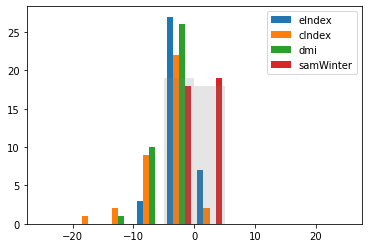

summerPos
<xarray.Dataset>
Dimensions:    ()
Data variables:
    eIndex     float64 -3.404
    cIndex     float64 -5.922
    dmi        float64 -2.656
    samSummer  float64 -15.6


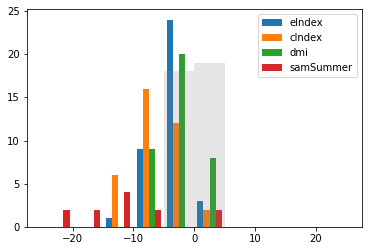

winterNeg
<xarray.Dataset>
Dimensions:    ()
Data variables:
    eIndex     float64 -1.58
    cIndex     float64 6.162
    dmi        float64 11.45
    samWinter  float64 -5.528


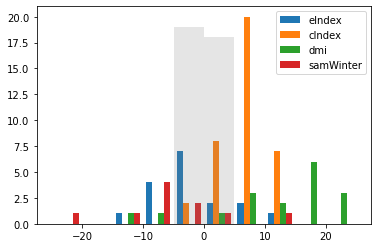

summerNeg
<xarray.Dataset>
Dimensions:    ()
Data variables:
    eIndex     float64 0.9272
    cIndex     float64 9.371
    dmi        float64 7.804
    samSummer  float64 0.6524


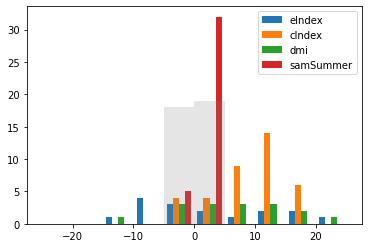

In [23]:
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        compounds=['eIndex','cIndex','dmi','sam'+iSeason.capitalize()]#,'samSummer','samWinter']

        print(iSeason+iFire.capitalize())
        
        #plot frequency of anoms, seperated by each compound
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allEventsXr[compounds].sel(
                                    experiment='ssp585',
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).mean(['year','lat','lon'])
        print(eventAnoms.mean('model'))

        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=np.arange(-25,26,5)
        )

        plt.legend(compounds)
        
        # in grey background, plot frequency of anoms for whole time period
        allYears=domain(
            prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
        ).mean(['year','lat','lon'])
        
        n=plt.hist(
            allYears.values.flatten(),
            bins=np.arange(-25,26,5), 
            alpha=0.2,
            color='grey'
        )
        
        plt.show()

Fire:pos
winter


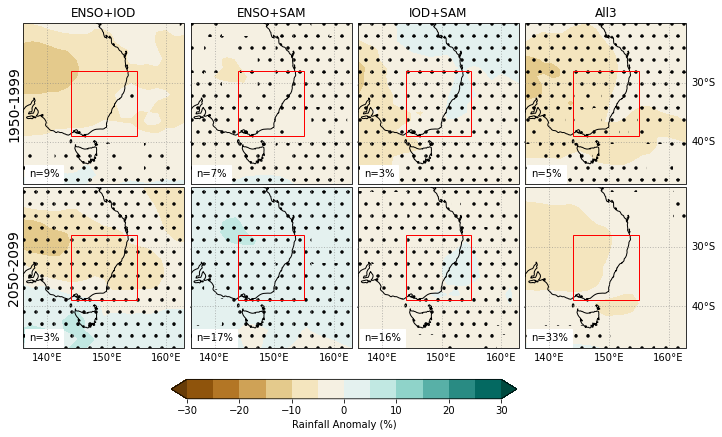

summer


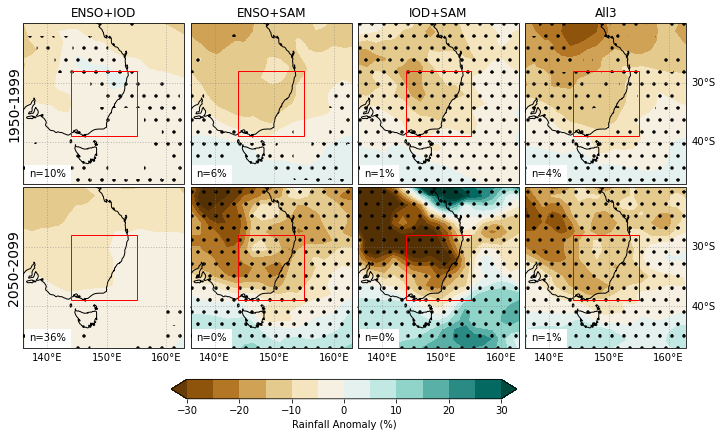

Fire:neg
winter


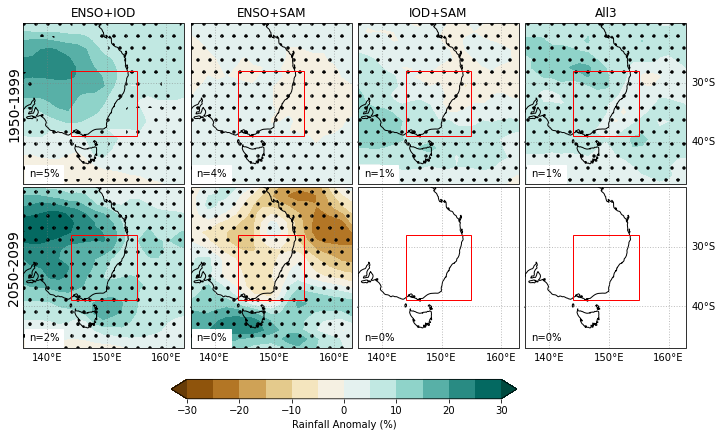

summer


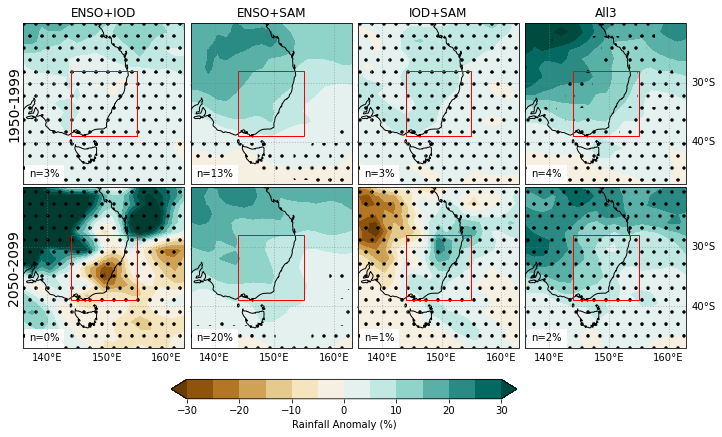

In [24]:


for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=multiPlotter(
            detrend(prXr[iSeason.capitalize()+' Rain']), #sourceData
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        plt.show()
        
